In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM


from scipy import stats

import random

import glob

import warnings  
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def trainModel(train):
    """
    Training LSTM model
    input:
        train: training dataframe
    output:
        lstm_model: trainied lstm model
    """
    
    #scaling => translates each feature individually such that it is in the given range on the training set
    #to ensure the unit if our data is not a factor

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_sc = scaler.fit_transform(train)

    #Reshaping the data to work for an LSTM network

    train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)


    for s in range(1,2):
        train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)

    X_train = train_sc_df.dropna().drop('Y', axis=1)
    y_train = train_sc_df.dropna().drop('X_1', axis=1)


    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()


    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
   

    print('Train shape: ', X_train_lmse.shape)
    

    lstm_model = Sequential()
    lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=10, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

    return lstm_model

def testModel(lstm_model,test):
    """
    Testing the LSTM model
    input:
        test: testing dataframe
        lstm_model: trainied lstm model
    output:
        lstm_pred: inverse scaled dataframe of predicted values
        test_val: inverse scaled dataframe of original values
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_sc = scaler.fit_transform(test)
    X_test = test_sc[:-1]
    y_test = test_sc[1:]
    test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)
    for s in range(1,2):
        test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)


    X_test = test_sc_df.dropna().drop('Y', axis=1)
    y_test = test_sc_df.dropna().drop('X_1', axis=1)

    X_test = X_test.as_matrix()
    y_test = y_test.as_matrix()
    
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    #print(X_test_lmse)
    y_pred_test_lstm = lstm_model.predict(X_test_lmse)
    
    #print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
    
    lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
   
    print('LSTM: %f'%lstm_test_mse)
    
    #inversing the scaling
    lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
    test_val = scaler.inverse_transform(y_test)
    
    return lstm_pred, test_val


def trainingData():
    """
    Reading Train Data 
    input:
        none
    output:
        data: training dataframe with index => DisplayTime value => GlucoseValues
    """
    path ='/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/train' # use your path
    all_files = glob.glob(path + "/*.csv")

    li = []

    for filename in all_files:

        df = pd.read_csv(filename, index_col=None, header=0)

        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    
    frame['timeStamp'] = frame['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    frame = frame.set_index(['timeStamp'], drop=True)
    
    #data.head()
    
    return frame

def testingData():
    """
    Reading Test Data 
    input:
        none
    output:
        data: testing dataframe with index => DisplayTime value => GlucoseValues
    """
    diabetic_1 = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID01.csv")
    diabetic_2 = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID11.csv")
    prediabetic = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID21.csv")
    nondiabetic = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID29.csv")
    
    diabetic_1['timeStamp'] = diabetic_1['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    diabetic_1 = diabetic_1.set_index(['timeStamp'], drop=True)
    
    prediabetic['timeStamp'] = prediabetic['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    prediabetic = prediabetic.set_index(['timeStamp'], drop=True)
    
    nondiabetic['timeStamp'] = nondiabetic['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    nondiabetic = nondiabetic.set_index(['timeStamp'], drop=True)
    
    diabetic_2['timeStamp'] = diabetic_2['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    diabetic_2 = diabetic_2.set_index(['timeStamp'], drop=True)
    
    return diabetic_1, diabetic_2, prediabetic, nondiabetic
    
    

def plot(lstm_pred, test_val):
    #plotting true values and lstm predicted values
    #these are original values
    
    plt.figure(figsize=(20, 8))
    
    
    plt.plot(lstm_pred, label='LSTM', color='red', linewidth=2)
    plt.plot(test_val, label='True', color='#2280f2', linewidth=2.5)
    
    plt.title("LSTM's Prediction")
    
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.legend()
    plt.show();
    
def getMetrics(lstm_pred, test_val):
    #IOA
    ioa_val = index_agreement(lstm_pred,test_val)
    print("Index of Agreement is: " + str(ioa_val))

    #MAE
    mae_val = mae(lstm_pred,test_val)
    print("Mean Absolute Error is: " + str(mae_val))

    #RMSE
    rmse_val = rmse(lstm_pred,test_val)
    print("Root Mean Squared Error is: " + str(rmse_val))
    
    #MAD
    mad_val = mad(lstm_pred)
    print("Mean Absolute Difference is:: " + str(mad_val))
    
    #FB
    fb_val = fracBias(lstm_pred,test_val)
    print("Fractional Bias is: " + str(rmse_val))
    
    #MAPE
    mape_val = mape(lstm_pred,test_val)
    print("Mean Absolute Percentage Error is: " + str(mape_val))
    
    
    
def index_agreement(s,o):
    """
    index of agreement
    input:
        s: prediceted
        o: original
    output:
        ia: index of agreement
    """
    
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    
    return ia

def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: prediceted
        o: original
    output:
        rmses: root mean squared error
    """
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    input:
        s: prediceted
        o: original
    output:
        maes: mean absolute error
    """
    return np.mean(abs(s-o))


def mad(s):
    """
    Mean Absolute Difference
    input:
        s: prediceted
    output:
        mad: mean absolute error
    """
  
    return stats.median_absolute_deviation(s)
    


def mape(y_pred,y_true):
    """
    Mean Absolute Percentage error
    input:
        y_pred: prediceted
        y_true: original
    output:
        mape: Mean Absolute Percentage error
    """

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def fracBias(s,o):
    """
    Fractional Bias
    input:
        s: prediceted
        o: original
    output:
        fracBias: Fractional Bias
    """
    
    return np.mean(np.abs((o - s) / ((o + s)/2)))
    


def createGap(data):
    """
    Creating Gap indexes
    input:
        data: dataframe with index => DisplayTime value => GlucoseValues
    output:
        start: seed
        end: seed+gap (gap=500)
    """
    
    seed = random.randint(500,len(data)-500)
    
    return seed,seed+499


def faultyData(df,start,end):
    """
    Creating a Gap
    input:
        start: seed
        end: seed+gap (gap=300)
    output:
        df: dataframe with index => DisplayTime value => GlucoseValues and a gap from start to end (inputs)
    """
    
    #df = readData()
    for i in range(start,end):
        df['glucoseValue'][i]=0
    
    return df

def summaryPlot(p1,t1,p2,t2,p3,t3,p4,t4):
    
    plt.figure(figsize=(20, 20))

    plt.subplot(2, 2, 1)
    plt.plot(p1, label='LSTM', color='red', linewidth=2)
    plt.plot(t1, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Diabetic - 1")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(p2, label='LSTM', color='red', linewidth=2)
    plt.plot(t2, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Diabetic - 2")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(p3, label='LSTM', color='red', linewidth=2)
    plt.plot(t3, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Prediabetic")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(p4, label='LSTM', color='red', linewidth=2)
    plt.plot(t4, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Nondiabetic")
    plt.legend()
    
    
    plt.show();
    

In [3]:
training_data = trainingData()

In [4]:
lstmModel = trainModel(training_data)

Train shape:  (20062, 1, 1)
Epoch 1/10
20062/20062 [==============================] - 61s 3ms/step - loss: 2.1727e-04
Epoch 2/10
20062/20062 [==============================] - 47s 2ms/step - loss: 1.8087e-04
Epoch 3/10
20062/20062 [==============================] - 56s 3ms/step - loss: 1.8018e-04
Epoch 4/10
20062/20062 [==============================] - 48s 2ms/step - loss: 1.8078e-04
Epoch 5/10
20062/20062 [==============================] - 53s 3ms/step - loss: 1.8218e-04
Epoch 00005: early stopping


In [5]:
diabetic_1, diabetic_2 , prediabetic, non_diabetic = testingData()
diabetic_1_faulty, diabetic_2_faulty, prediabetic_faulty, non_diabetic_faulty = testingData()


In [6]:
start, end = createGap(diabetic_1)
gap_tester_diabetic_1 = diabetic_1.iloc[start:end+2]
diabetic_1_faulty = faultyData(diabetic_1_faulty,start,end+1)

500/500 [==============================] - 1s 1ms/step: 
LSTM: 0.003323


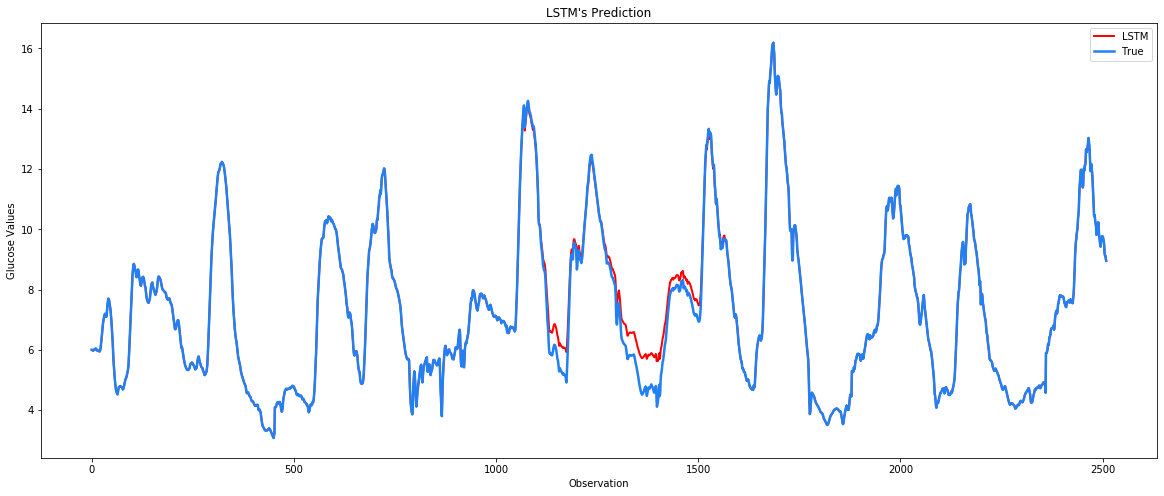

Index of Agreement is: 0.9865138811344304
Mean Absolute Error is: 0.4651610384979248
Root Mean Squared Error is: 0.5847844888555729
Mean Absolute Difference is:: [2.6102815]
Fractional Bias is: 0.5847844888555729
Mean Absolute Percentage Error is: 7.673347137335035


In [7]:
predicted, true = testModel(lstmModel,gap_tester_diabetic_1)

for i in range(0,500):
     diabetic_1_faulty['glucoseValue'][start+i] = predicted[i][0]

plot(diabetic_1_faulty['glucoseValue'].tolist(),diabetic_1['glucoseValue'].tolist())
getMetrics(predicted,true)

In [8]:
#diabetic_1_faulty, diabetic_2_faulty, prediabetic_faulty, non_diabetic_faulty = testingData()
start, end = createGap(diabetic_2)
gap_tester_diabetic_2 = diabetic_2.iloc[start:end+2]
diabetic_2_faulty = faultyData(diabetic_2_faulty,start,end+1)

In [9]:
#diabetic_2_faulty['glucoseValue'][start+499]

500/500 [==============================] - 1s 1ms/step
LSTM: 0.004708


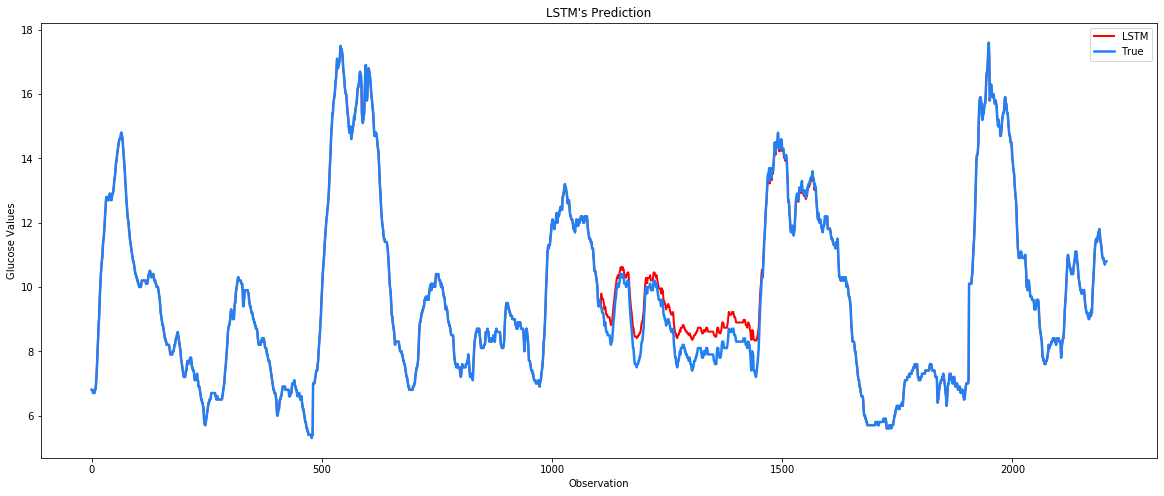

Index of Agreement is: 0.9834839886115494
Mean Absolute Error is: 0.44280344734191895
Root Mean Squared Error is: 0.5214696108583762
Mean Absolute Difference is:: [1.2248824]
Fractional Bias is: 0.5214696108583762
Mean Absolute Percentage Error is: 5.1959109391801395


In [10]:
predicted, true = testModel(lstmModel,gap_tester_diabetic_2)

for i in range(0,500):
    diabetic_2_faulty['glucoseValue'][start+i] = predicted[i][0]
    
plot(diabetic_2_faulty['glucoseValue'].tolist(),diabetic_2['glucoseValue'].tolist())
getMetrics(predicted,true)

In [11]:
start, end = createGap(prediabetic)
gap_tester_prediabetic = prediabetic.iloc[start:end+2]
prediabetic_faulty = faultyData(prediabetic_faulty,start,end+1)

500/500 [==============================] - 0s 965us/step
LSTM: 0.002353


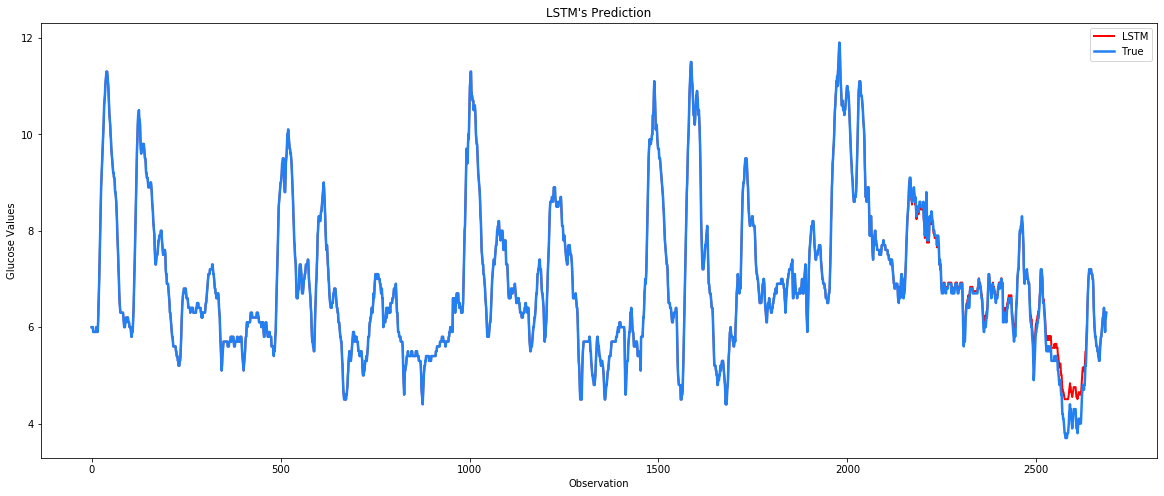

Index of Agreement is: 0.9877473718339819
Mean Absolute Error is: 0.1839063186645508
Root Mean Squared Error is: 0.2619162113092219
Mean Absolute Difference is:: [0.77847576]
Fractional Bias is: 0.2619162113092219
Mean Absolute Percentage Error is: 3.506748633122115


In [12]:
predicted, true = testModel(lstmModel,gap_tester_prediabetic)

for i in range(0,500):
    prediabetic_faulty['glucoseValue'][start+i] = predicted[i][0]
    
plot(prediabetic_faulty['glucoseValue'].tolist(),prediabetic['glucoseValue'].tolist())
getMetrics(predicted,true)

In [13]:
start, end = createGap(non_diabetic)
gap_tester_non_diabetic = non_diabetic.iloc[start:end+2]
non_diabetic_faulty = faultyData(non_diabetic_faulty,start,end+1)

500/500 [==============================] - 1s 1ms/step
LSTM: 0.003420


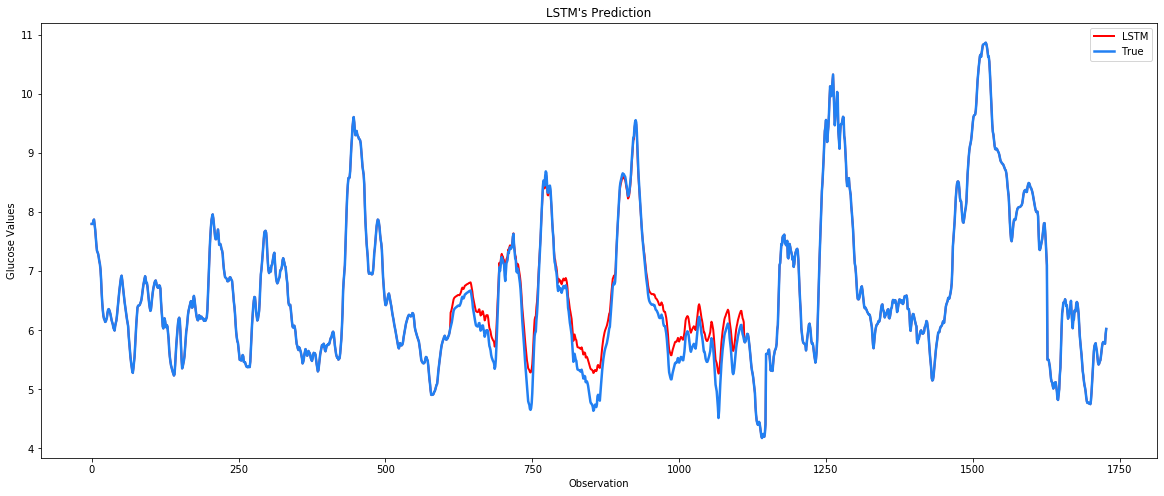

Index of Agreement is: 0.9781975515147431
Mean Absolute Error is: 0.2555695442352295
Root Mean Squared Error is: 0.2949217040464219
Mean Absolute Difference is:: [0.72163945]
Fractional Bias is: 0.2949217040464219
Mean Absolute Percentage Error is: 4.4597497664635295


In [14]:
predicted, true = testModel(lstmModel,gap_tester_non_diabetic)

for i in range(0,500):
    non_diabetic_faulty['glucoseValue'][start+i] = predicted[i][0]
    
plot(non_diabetic_faulty['glucoseValue'].tolist(),non_diabetic['glucoseValue'].tolist())
getMetrics(predicted,true)

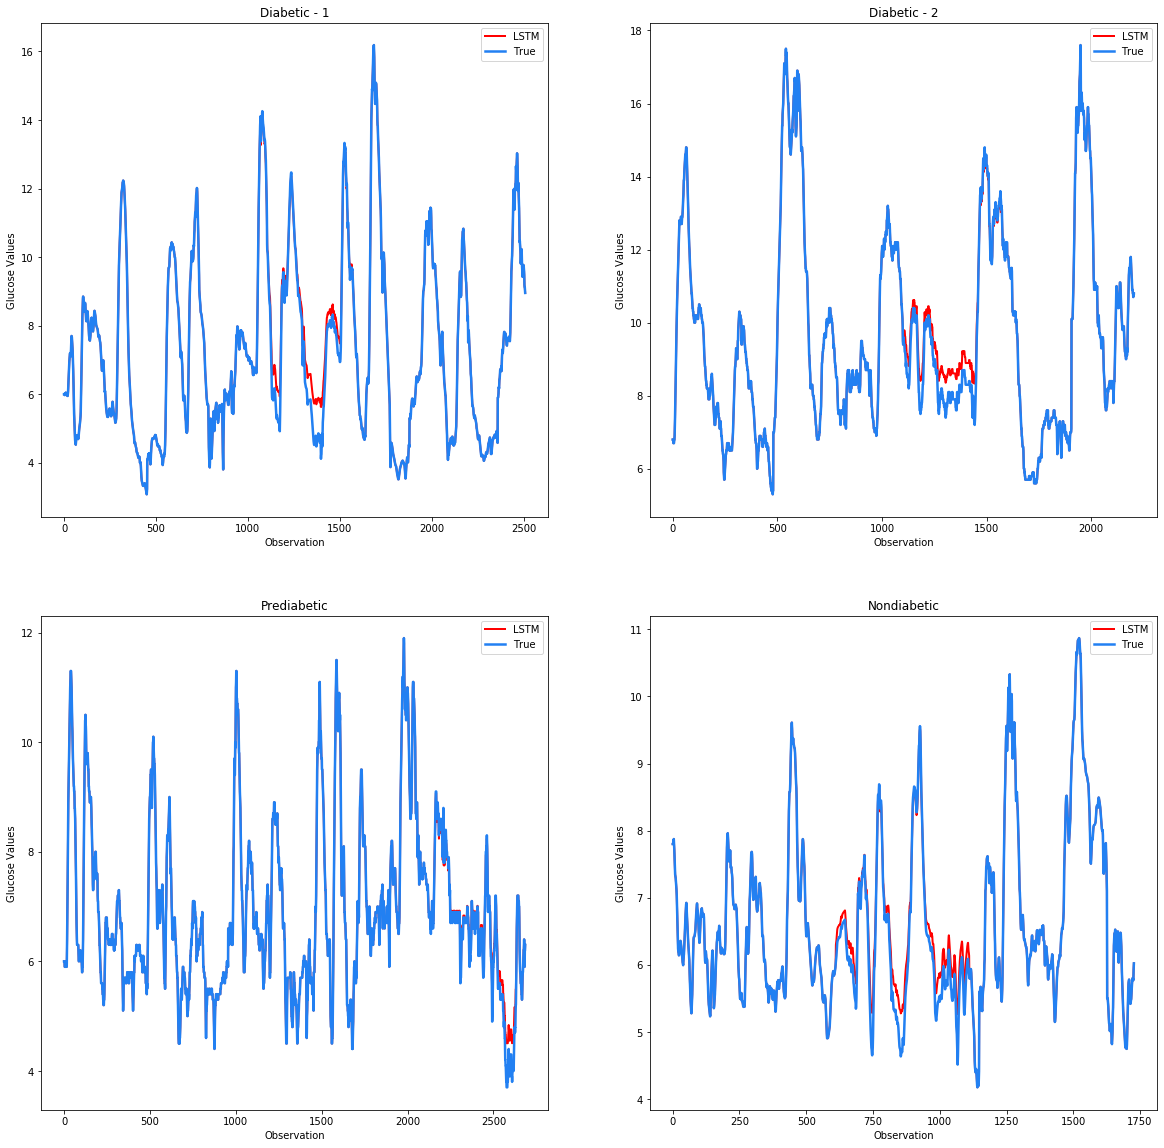

In [15]:
summaryPlot(diabetic_1_faulty['glucoseValue'].tolist(),diabetic_1['glucoseValue'].tolist(),diabetic_2_faulty['glucoseValue'].tolist(),diabetic_2['glucoseValue'].tolist(),prediabetic_faulty['glucoseValue'].tolist(),prediabetic['glucoseValue'].tolist(),non_diabetic_faulty['glucoseValue'].tolist(),non_diabetic['glucoseValue'].tolist())